In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import sys
sys.path.append("/home/mylab-pharma/Code/tuele/pan_HDAC/mylab_panHDAC-master/src/common")
from pharmacy_common import PharmacyCommon

#class to encode smiles
common = PharmacyCommon()

Import the dataset

In [2]:
train_dataset = pd.read_excel('../../data/train_test_data/NoCL/20240321_pan_HDAC_train_test_data.xlsx',sheet_name='train_dataset')
validation_dataset = pd.read_excel("../../data/train_test_data/NoCL/20240321_pan_HDAC_train_test_data.xlsx", sheet_name='validation_dataset')
test_dataset = pd.read_excel("../../data/train_test_data/NoCL/20240321_pan_HDAC_train_test_data.xlsx", sheet_name='test_dataset')
print(len(train_dataset),len(validation_dataset), len(test_dataset))

1528 328 327


In [3]:
train_dataset.head(10)

,Code,SMILES,Bioactivity
0,415897,CC(Nc1ccc(CN(CCC=C2CCC(NO)=O)C2=O)cc1)=O,inactive
1,1589183,COc(cc(/C=C/C(Nc(cccc1)c1N)=O)cc1)c1OCC(Nc(cc1...,inactive
2,1161066,CC[C@H](C)[C@@H](C(N(Cc1c(C2)ccc(OCC(NO)=O)c1)...,active
3,2100074,CC(c1ccccc1)Nc1ncnc2c1cc(-c1ccc(CN3CCN(CCOCCCC...,inactive
4,386804,CC(C)SC(SCC(c1ccc(C)cc1)=O)=S,inactive
5,467667,CCOC(SCC(c(cc1)ccc1NC(C)=O)=O)=S,inactive
6,390739,ONC(/C=C/c1cccc(C(c2cc(cccc3)c3[nH]2)=O)c1)=O,active
7,440474,ONC(CCCCCNC(Nc1cc(-c2nc(cccc3)c3[o]2)ccc1)=O)=O,active
8,2460036,CN1C(SCc(cc2)ccc2C(Nc(cccc2)c2N)=O)=Nc(cc(cc2)...,inactive
9,440227,CCC(c1nc(cccc2)c2[n]1CC)c1ccc(/C=C/C(NO)=O)cc1,active


In [4]:
#encoding smiles 
fpt_bits = 1024
X_train = common.gen_ecfp4_fpts(train_dataset['SMILES'],fpt_bits)
X_validation = common.gen_ecfp4_fpts(validation_dataset['SMILES'],fpt_bits)
X_test = common.gen_ecfp4_fpts(test_dataset['SMILES'],fpt_bits)

Progress:   0%|          | 0/1528 [00:00<?, ?it/s][21:12:57] DEPRECATION WARNING: please use MorganGenerator
[21:12:57] DEPRECATION WARNING: please use MorganGenerator
[21:12:57] DEPRECATION WARNING: please use MorganGenerator
[21:12:57] DEPRECATION WARNING: please use MorganGenerator
[21:12:57] DEPRECATION WARNING: please use MorganGenerator
[21:12:57] DEPRECATION WARNING: please use MorganGenerator
[21:12:57] DEPRECATION WARNING: please use MorganGenerator
[21:12:57] DEPRECATION WARNING: please use MorganGenerator
[21:12:57] DEPRECATION WARNING: please use MorganGenerator
[21:12:57] DEPRECATION WARNING: please use MorganGenerator
[21:12:57] DEPRECATION WARNING: please use MorganGenerator
[21:12:57] DEPRECATION WARNING: please use MorganGenerator
[21:12:57] DEPRECATION WARNING: please use MorganGenerator
[21:12:57] DEPRECATION WARNING: please use MorganGenerator
[21:12:57] DEPRECATION WARNING: please use MorganGenerator
[21:12:57] DEPRECATION WARNING: please use MorganGenerator
[21:12

In [5]:
print(X_train.shape, X_validation.shape, X_test.shape)

(1528, 1024) (328, 1024) (327, 1024)


In [6]:
# encoding the label
import sklearn.preprocessing as preprocessing
y_train = np.array(train_dataset['Bioactivity'])
y_validation = np.array(validation_dataset['Bioactivity'])
y_test = np.array(test_dataset['Bioactivity'])

#Original data
print("Original data:")
print(y_train[0:5])
print(y_test[0:5])
print(y_validation[0:5])

#label encoding
label_encoder = preprocessing.LabelEncoder()
y_train  = label_encoder.fit_transform(y_train)
y_validation = label_encoder.fit_transform(y_validation)
y_test = label_encoder.fit_transform(y_test)
#Class encoded
print("Class encoded:")
print(list(label_encoder.classes_))
print(label_encoder.transform(label_encoder.classes_))
print("Encoded data:")
print(y_train[0:5])
print(y_test[0:5])
print(y_validation[0:5])

Original data:
['inactive' 'inactive' 'active' 'inactive' 'inactive']
['active' 'active' 'active' 'inactive' 'active']
['active' 'active' 'inactive' 'inactive' 'inactive']
Class encoded:
['active', 'inactive']
[0 1]
Encoded data:
[1 1 0 1 1]
[0 0 0 1 0]
[0 0 1 1 1]


In [7]:
#converting to tensor 
X_train_df = pd.DataFrame(X_train)
X_validation_df = pd.DataFrame(X_validation)
X_test_df = pd.DataFrame(X_test)

X_train = torch.tensor(X_train_df.values, dtype=torch.float32)
X_validation = torch.tensor(X_validation_df.values, dtype=torch.float32)
X_test = torch.tensor(X_test_df.values, dtype=torch.float32)

y_train_df = pd.DataFrame(y_train)
y_validation_df = pd.DataFrame(y_validation)
y_test_df = pd.DataFrame(y_test)

y_train = torch.tensor(y_train_df.values, dtype=torch.float32)
y_validation = torch.tensor(y_validation_df.values, dtype=torch.float32)
y_test = torch.tensor(y_test_df.values, dtype=torch.float32)

In [8]:
# Create train and test datasets
train_dataset = TensorDataset(X_train, y_train)
validation_dataset= TensorDataset(X_validation, y_validation)
test_dataset = TensorDataset(X_test, y_test)
print(len(train_dataset), len(validation_dataset), len(test_dataset))

1528 328 327


Construct and sanity-check the model

In [9]:
data_train = X_train
data_valdation = X_validation
data_test = X_test

labels_validation = y_validation
labels_test = y_test
labels_train= y_train.float()
print(len(data_train), len(labels_train),len(data_valdation),
    len(labels_validation), len(data_test), len(labels_test))
print(data_train)
print(labels_train)

1528 1528 328 328 327 327
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[1.],
        [1.],
        [0.],
        ...,
        [0.],
        [1.],
        [1.]])


Model

In [10]:
# model
class ann_try(nn.Module):
    def __init__(self, input_dim=len(X_train[0]),layer1=256,layer2=128,drp=.2,output=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim,layer1),
            nn.ReLU(),
            nn.Dropout(drp),
            nn.Linear(layer1,layer2),
            nn.ReLU(),
            nn.Dropout(drp),
            nn.Linear(layer2,output),
            nn.Sigmoid(),
        )
    def forward(self,input):
        return self.net(input)

In [11]:
# trainning
def training(x_train = X_train,y_train=y_train,x_validation = X_validation,
            #  y_validation = y_validation,lr=0.001,l2=0.001,batch_size=64,epochs=100):
            y_validation = y_validation,lr=0.007206041689487159,l2=0.004176049826978714,batch_size=128,epochs=500):
    torch.manual_seed(0)
    losses=[]
    train_ds = TensorDataset(x_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size)
    model = ann_try()
    loss_func = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=l2)
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        if epoch==0 or  epoch % 2 == 0:
            print(loss)
        losses.append(loss)
    losses_tensor = torch.tensor(losses)
    plt.title("Loss in training")
    plt.xlabel('Numepoch')
    plt.ylabel('Loss_value')
    plt.plot(losses_tensor.detach())
    
    model.eval()
    y_pred_train = model(x_train)>.5
    acc_train = 100*torch.mean((y_pred_train == y_train).float())
    y_pred = model(x_validation)>.5
    acc_val = 100*torch.mean((y_pred == y_validation).float())

    # mse = mean_squared_error(model(x_validation).detach().numpy(),y_.detach().numpy())
    print('Accuracy on train set:' ,acc_train)
    print('Accuracy on validation set:' ,acc_val)

    return acc_train, acc_val #to specify what to maximize in this function

tensor(0.5178, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3747, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2974, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3022, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1955, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3025, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2837, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2429, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2208, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1782, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2431, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1443, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1217, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1353, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1970, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1669, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1097, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1468, grad_fn=<Bina

(tensor(98.5602), tensor(81.0976))

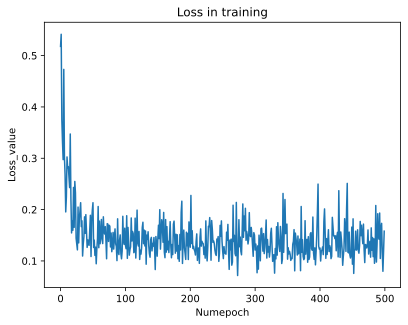

In [12]:
training(X_train,y_train,X_validation,y_validation)

10-fold cross validation 

In [13]:
X_train_val = torch.cat((X_train,X_validation))
y_train_val = torch.cat((y_train,y_validation))
print(X_train_val.shape, y_train_val.shape)

torch.Size([1856, 1024]) torch.Size([1856, 1])


In [14]:
from sklearn.model_selection import cross_val_score, KFold

def training_with_K_fold(x_train=X_train, y_train=y_train,
             lr=0.007206041689487159, l2=0.004176049826978714, batch_size=128, epochs=500, num_folds=10):
    torch.manual_seed(0)
    # losses = []
    model = ann_try()
    loss_func = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    
    kf = KFold(n_splits=num_folds, shuffle=True)
    fold_train_accuracies = []
    fold_val_accuracies = []
    fold_train_losses = []
    fold_val_losses = []

    for fold, (train_index, val_index) in enumerate(kf.split(x_train)):
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]
        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        train_ds = TensorDataset(x_train_fold, y_train_fold)
        train_dl = DataLoader(train_ds, batch_size=batch_size)

        for epoch in range(epochs):
            model.train()
            for xb, yb in train_dl:
                pred = model(xb)
                loss = loss_func(pred, yb)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            # losses.append(loss)

        model.eval()
        # Train dataset
        y_pred_train = model(x_train_fold)
        loss_train = loss_func(y_pred_train, y_train_fold)
        y_pred_train_bin = y_pred_train > 0.5
        acc_train = 100 * torch.mean((y_pred_train_bin == y_train_fold).float())
        # Validation dataset
        y_pred_val = model(x_val_fold)
        loss_val = loss_func(y_pred_val, y_val_fold)
        y_pred_val_bin = y_pred_val > 0.5
        acc_val = 100 * torch.mean((y_pred_val_bin == y_val_fold).float())
        
        fold_train_losses.append(loss_train)
        fold_val_losses.append(loss_val)

        fold_train_accuracies.append(acc_train)
        fold_val_accuracies.append(acc_val)

    average_train_accuracy = sum(fold_train_accuracies) / num_folds
    average_val_accuracy = sum(fold_val_accuracies) / num_folds
    print("Average Accuracy on train set:", average_train_accuracy)
    print("Average Accuracy on validation set:", average_val_accuracy)

    return fold_train_losses, fold_val_losses, fold_train_accuracies, fold_val_accuracies

In [15]:
fold_train_losses, fold_val_losses,fold_train_accuracies, fold_val_accuracies = training_with_K_fold(x_train=X_train_val, y_train=y_train_val)

Average Accuracy on train set: tensor(96.3003)
Average Accuracy on validation set: tensor(81.1430)


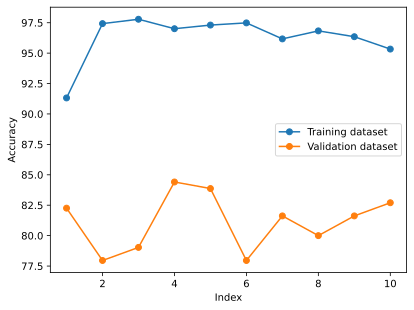

In [16]:
fold_train_accuracies_tensor = torch.tensor(fold_train_accuracies)
fold_val_accuracies_tensor = torch.tensor(fold_val_accuracies)
index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.plot(index,fold_train_accuracies_tensor.detach().numpy(), marker='o', label='Training dataset')
plt.plot(index,fold_val_accuracies_tensor.detach().numpy(), marker='o', label='Validation dataset')

# plt.plot(fold_train_losses.detach().numpy(), index, marker='o', label='Training dataset')
# plt.plot(fold_val_losses.detach().numpy(), index, marker='o', label='Validation dataset')
plt.xlabel('Index')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

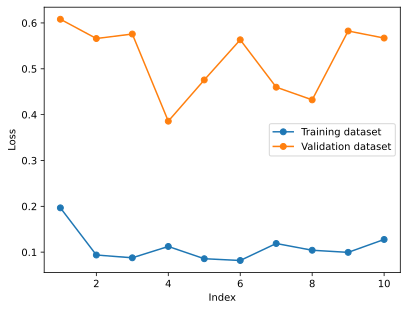

In [17]:
fold_train_losses_tensor = torch.tensor(fold_train_losses)
fold_val_losses_tensor = torch.tensor(fold_val_losses)
index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.plot(index,fold_train_losses_tensor.detach().numpy(), marker='o', label='Training dataset')
plt.plot(index,fold_val_losses_tensor.detach().numpy(), marker='o', label='Validation dataset')

# plt.plot(fold_train_losses.detach().numpy(), index, marker='o', label='Training dataset')
# plt.plot(fold_val_losses.detach().numpy(), index, marker='o', label='Validation dataset')
plt.xlabel('Index')
plt.ylabel('Loss')
plt.legend()
plt.show()

ANN with drop out 

In [18]:
# trainning
def training_with_dropout(x_train = X_train,y_train=y_train,x_validation = X_validation,
            #  y_validation = y_validation,lr=0.001,l2=0.001,batch_size=64,epochs=100):
            y_validation = y_validation,lr=0.007206041689487159,l2=0.004176049826978714,batch_size=128,epochs=500):
    torch.manual_seed(0)
    losses=[]

    train_ds = TensorDataset(x_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size)
    #model 
    # model
    class ann_try_tmp(nn.Module):
        def __init__(self, input_dim= len(x_train[0]),layer1=512,layer2=256,drp=.2,output=1):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim,layer1),
                nn.ReLU(),
                nn.Dropout(drp),
                nn.Linear(layer1,layer2),
                nn.ReLU(),
                nn.Dropout(drp),
                nn.Linear(layer2,output),
                nn.Sigmoid(),
            )
        def forward(self,input):
            return self.net(input)

    model = ann_try_tmp()
    loss_func = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=l2)
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        losses.append(loss)
    losses_tensor = torch.tensor(losses)
    
    # plt.title("Loss in training")
    # plt.xlabel('Numepoch')
    # plt.ylabel('Loss_value')
    # plt.plot(losses_tensor.detach())
    
    model.eval()
    y_pred_train = model(x_train)>.5
    acc_train = 100*torch.mean((y_pred_train == y_train).float())
    y_pred = model(x_validation)>.5
    acc_val = 100*torch.mean((y_pred == y_validation).float())

    # mse = mean_squared_error(model(x_validation).detach().numpy(),y_.detach().numpy())

    # print('Accuracy on validation set:' ,acc_train)
    # print('Accuracy on validation set:' ,acc_val)

    return acc_train, acc_val #to specify what to maximize in this function

In [9]:
len(X_train)

1528

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
start_index = 100
step = 50
num_data = []
acc_train = []
acc_val = []
for i in range(start_index, len(X_train), step):
    x_train_i = X_train[:i]
    y_train_i = y_train[:i]
    rf_morgan2 = RandomForestClassifier(criterion='entropy', n_estimators=300, random_state=42)
    rf_morgan2.fit(x_train_i, y_train_i)
    y_pred_train = rf_morgan2.predict(x_train_i)
    y_pred_val = rf_morgan2.predict(X_validation)
    acc_train_i = accuracy_score(y_train_i, y_pred_train)
    acc_train.append(acc_train_i)
    acc_val_i = accuracy_score(y_validation, y_pred_val)
    acc_val.append(acc_val_i)
    num_data.append(i)


/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/sklearn/base.py:1

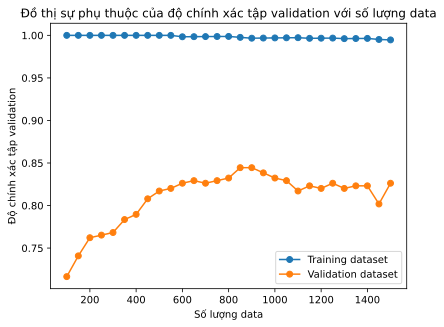

In [19]:
acc_train_tensor = torch.tensor(acc_train)
acc_val_tensor = torch.tensor(acc_val)
plt.plot(num_data,acc_train_tensor.detach().numpy(), marker='o', label='Training dataset')
plt.plot(num_data,acc_val_tensor.detach().numpy(), marker='o', label='Validation dataset')

# plt.plot(fold_train_losses.detach().numpy(), index, marker='o', label='Training dataset')
# plt.plot(fold_val_losses.detach().numpy(), index, marker='o', label='Validation dataset')
plt.xlabel('Số lượng data')
plt.ylabel('Độ chính xác tập validation')
plt.title("Đồ thị sự phụ thuộc của độ chính xác tập validation với số lượng data")
plt.legend()
plt.show()

In [16]:
len(num_data)

29

In [21]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Chuyển đổi danh sách thành mảng NumPy
acc_val = np.array(acc_val)
num_data = np.array(num_data)

# Khởi tạo và huấn luyện mô hình hồi quy tuyến tính
regressor = LinearRegression()
regressor.fit(acc_val.reshape(-1, 1), num_data.reshape(-1, 1))

LinearRegression()

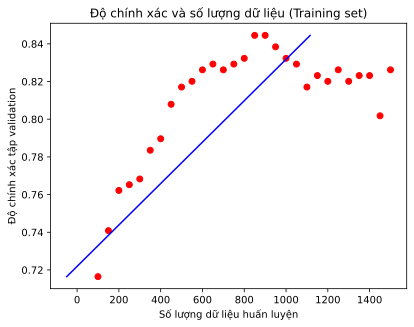

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Chuyển đổi danh sách thành mảng NumPy
acc_val = np.array(acc_val)
num_data = np.array(num_data)

# Khởi tạo và huấn luyện mô hình hồi quy tuyến tính
regressor = LinearRegression()
regressor.fit(acc_val.reshape(-1, 1), num_data.reshape(-1, 1))

# Trực quan hóa dữ liệu và đường hồi quy
plt.scatter( num_data,acc_val, color='red')
plt.plot( regressor.predict(acc_val.reshape(-1, 1)),acc_val, color='blue')
plt.title('Độ chính xác và số lượng dữ liệu (Training set)')
plt.xlabel('Số lượng dữ liệu huấn luyện')
plt.ylabel('Độ chính xác tập validation')
plt.show()

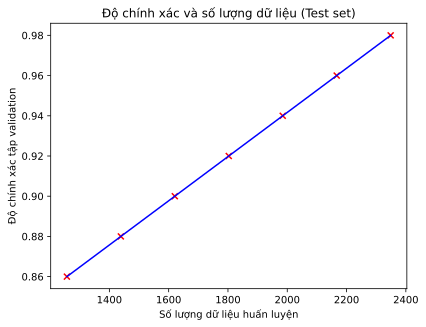

In [31]:
import matplotlib.pyplot as plt
import numpy as np
x_test = np.linspace(0.86, 0.98, num=7)
len(x_test)

# Vẽ đồ thị
plt.plot(regressor.predict(x_test.reshape(-1, 1)), x_test, color='blue')
plt.scatter(regressor.predict(x_test.reshape(-1, 1)), x_test, color='red', marker='x')
plt.title('Độ chính xác và số lượng dữ liệu (Test set)')
plt.xlabel('Số lượng dữ liệu huấn luyện')
plt.ylabel('Độ chính xác tập validation')
plt.show()

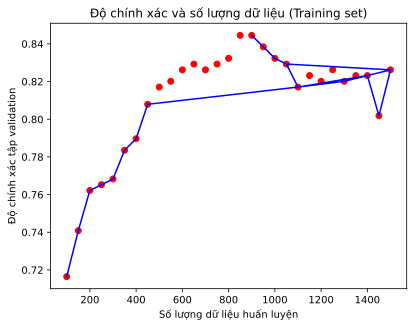

In [33]:
from sklearn import svm
import matplotlib.pyplot as plt
import numpy as np

# Chuyển đổi danh sách thành mảng NumPy
acc_val = np.array(acc_val)
num_data = np.array(num_data)

# Khởi tạo và huấn luyện mô hình SVM
svm_regression = svm.SVC(kernel='linear')
svm_regression.fit(acc_val.reshape(-1, 1), num_data)

# Trực quan hóa dữ liệu và đường biên phân loại
plt.scatter( num_data,acc_val, color='red')
plt.plot( svm_regression.predict(acc_val.reshape(-1, 1)),acc_val, color='blue')
plt.title('Độ chính xác và số lượng dữ liệu (Training set)')
plt.xlabel('Số lượng dữ liệu huấn luyện')
plt.ylabel('Độ chính xác tập validation')
plt.show()

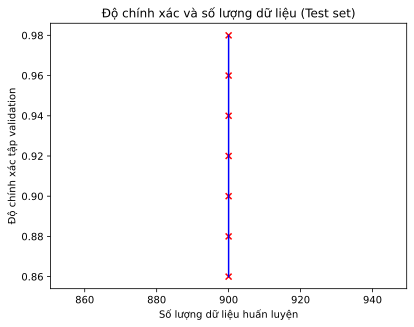

In [34]:
import matplotlib.pyplot as plt
import numpy as np
x_test = np.linspace(0.86, 0.98, num=7)
len(x_test)

# Vẽ đồ thị
plt.plot(svm_regression.predict(x_test.reshape(-1, 1)), x_test, color='blue')
plt.scatter(svm_regression.predict(x_test.reshape(-1, 1)), x_test, color='red', marker='x')
plt.title('Độ chính xác và số lượng dữ liệu (Test set)')
plt.xlabel('Số lượng dữ liệu huấn luyện')
plt.ylabel('Độ chính xác tập validation')
plt.show()

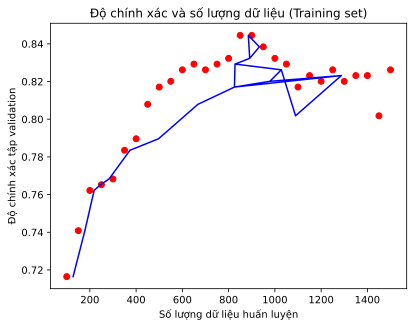

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
acc_val = np.array(acc_val)
num_data = np.array(num_data)

# Khởi tạo và huấn luyện mô hình SVM
tree_regression = RandomForestRegressor()
tree_regression.fit(acc_val.reshape(-1, 1), num_data)

# Trực quan hóa dữ liệu và đường biên phân loại
plt.scatter( num_data,acc_val, color='red')
plt.plot( tree_regression.predict(acc_val.reshape(-1, 1)),acc_val, color='blue')
plt.title('Độ chính xác và số lượng dữ liệu (Training set)')
plt.xlabel('Số lượng dữ liệu huấn luyện')
plt.ylabel('Độ chính xác tập validation')
plt.show()